In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread
import bcolz

import os

#### Methods

$normalization = v^{T}Dv$

$correlation = \frac{(v^{T}Ds)^2} {normalization}$

$score = \frac{v^{T}Lv}{normalization}$

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result

def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

def PRobjective(graph, seed, myImg):
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []    
    correlationList = []
    scoreList = []
    valueList = []
    
    exponential = -9
    correlation = 1 / len(graph) + 1 # to get into loop
    
    MAXITER = 21
    # MINITER = 4
    for i in range(MAXITER):
        # if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)

        print('--')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
        print('Heatmap:\n')
        heat = np.zeros(myImg.shape)
        for ii in range(myImg.shape[0]):
            for jj in range(myImg.shape[1]):
                heat[ii][jj] = v[ii * myImg.shape[1] + jj]    
        plt.imshow(heat, cmap='hot', interpolation='nearest')
        plt.show()
            
        # if i == MINITER:
        #    print('**')
        #    print('Starting correlation decrease check!')
            
        # if i >= MINITER and oldCorrelation * .99 < correlation:
        #    break
            
    print('****')
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.show()
    
    return [alphaList, correlationList, scoreList, valueList]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

#### Image

In [3]:
# 0cc6fc725d4b8818415ddc06823fce98
IMAGE = "0cc6fc725d4b8818415ddc06823fce98"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
# 140 row, 156 columns
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
for i in range(30, 111, 32):
    for j in range(50, 111, 30):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.959660202904
Score: 0.000539284364671
Heatmap:



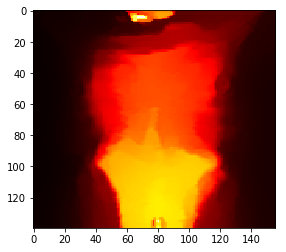

--
alpha: 2^-11
Correlation: 0.945632195119
Score: 0.000521215682916
Heatmap:



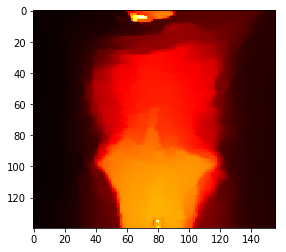

--
alpha: 2^-12
Correlation: 0.927958047327
Score: 0.000504978741528
Heatmap:



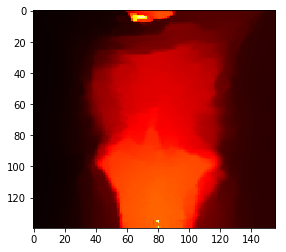

--
alpha: 2^-13
Correlation: 0.905888340927
Score: 0.000488798946435
Heatmap:



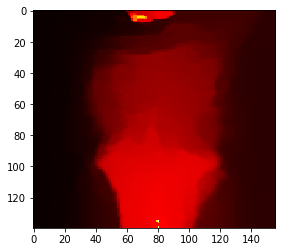

--
alpha: 2^-14
Correlation: 0.88241374008
Score: 0.00047380735717
Heatmap:



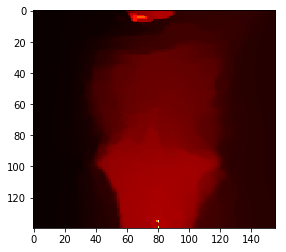

--
alpha: 2^-15
Correlation: 0.862083554478
Score: 0.00046178481629
Heatmap:



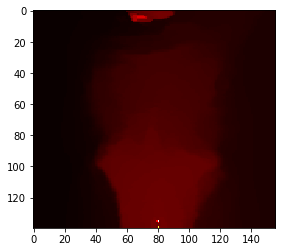

--
alpha: 2^-16
Correlation: 0.845001492179
Score: 0.000452053079355
Heatmap:



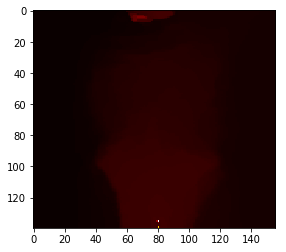

--
alpha: 2^-17
Correlation: 0.823407026569
Score: 0.000439976315699
Heatmap:



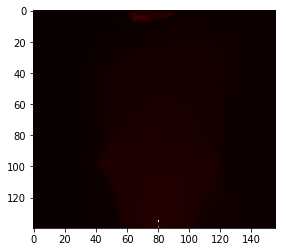

--
alpha: 2^-18
Correlation: 0.683421968877
Score: 0.000363638148766
Heatmap:



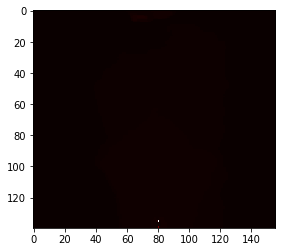

--
alpha: 2^-19
Correlation: 0.2631420256
Score: 0.00013821157948
Heatmap:



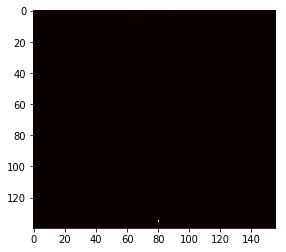

--
alpha: 2^-20
Correlation: 0.0986479255925
Score: 5.09793527361e-05
Heatmap:



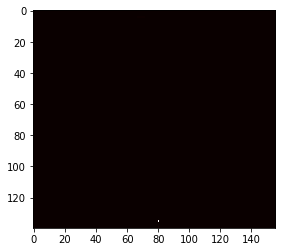

--
alpha: 2^-21
Correlation: 0.0283636196093
Score: 1.41682287483e-05
Heatmap:



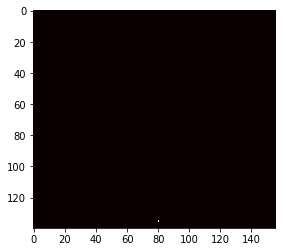

--
alpha: 2^-22
Correlation: 0.0130534318742
Score: 6.29894433051e-06
Heatmap:



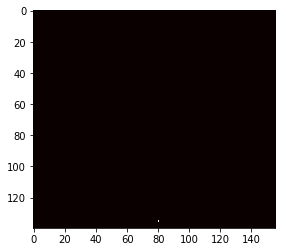

--
alpha: 2^-23
Correlation: 0.00610994972189
Score: 2.80372864582e-06
Heatmap:



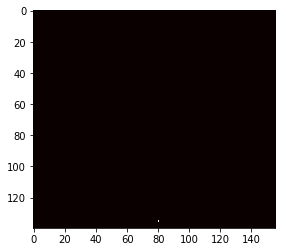

--
alpha: 2^-24
Correlation: 0.00066459263681
Score: 2.13412963792e-07
Heatmap:



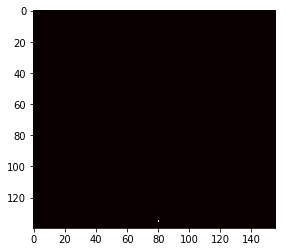

--
alpha: 2^-25
Correlation: 0.000147672700311
Score: 2.15080884625e-08
Heatmap:



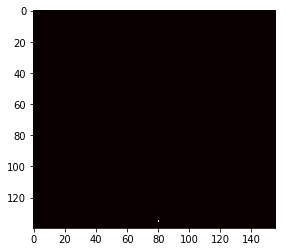

--
alpha: 2^-26
Correlation: 0.000157507903284
Score: 2.42942038144e-08
Heatmap:



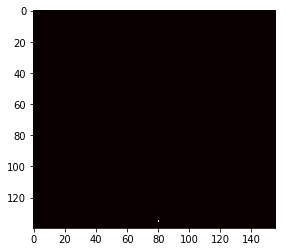

--
alpha: 2^-27
Correlation: 5.75138970827e-05
Score: 1.67764703427e-09
Heatmap:



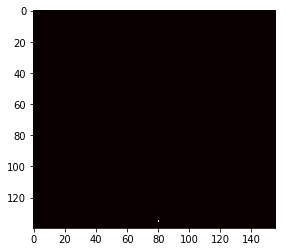

--
alpha: 2^-28
Correlation: 4.46536028613e-05
Score: 4.04119542069e-10
Heatmap:



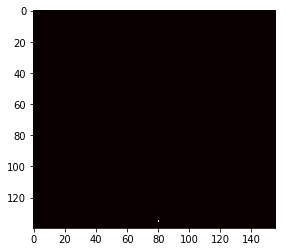

--
alpha: 2^-29
Correlation: 4.33565457815e-05
Score: 3.18274219005e-10
Heatmap:



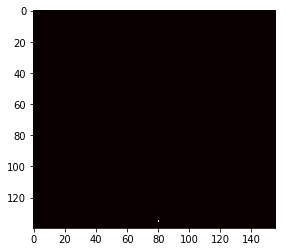

--
alpha: 2^-30
Correlation: 3.65500925897e-05
Score: 2.88604172597e-11
Heatmap:



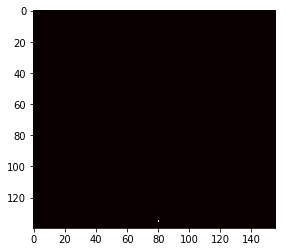

****


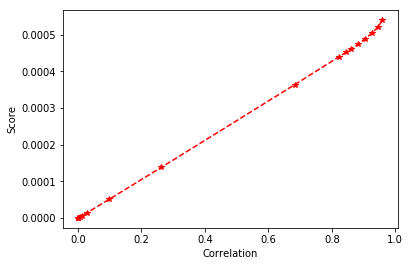

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.945464757382
Score: 0.000520991097636
Heatmap:



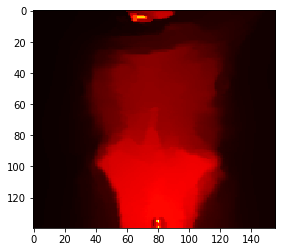

--
alpha: 2^-11
Correlation: 0.933911612194
Score: 0.000506053421572
Heatmap:



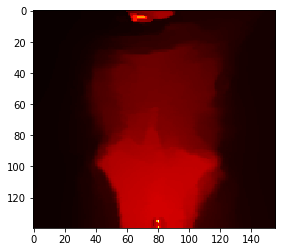

--
alpha: 2^-12
Correlation: 0.919766345369
Score: 0.000493088956064
Heatmap:



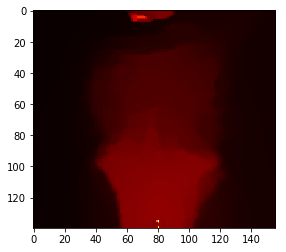

--
alpha: 2^-13
Correlation: 0.900674810208
Score: 0.000479213978787
Heatmap:



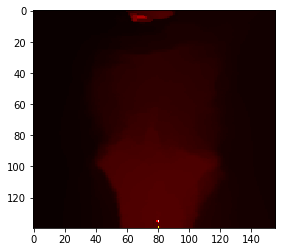

--
alpha: 2^-14
Correlation: 0.879358705529
Score: 0.000465749871654
Heatmap:



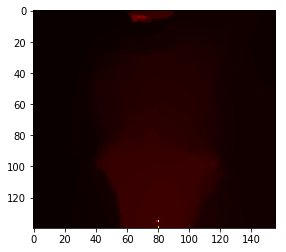

--
alpha: 2^-15
Correlation: 0.848187254166
Score: 0.000447569778993
Heatmap:



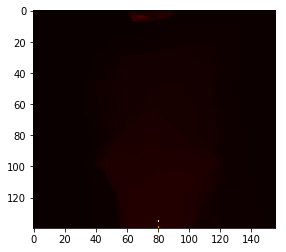

--
alpha: 2^-16
Correlation: 0.788029326381
Score: 0.000414092737276
Heatmap:



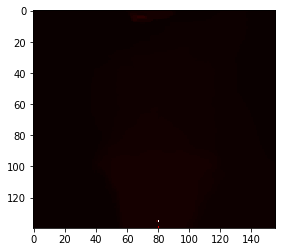

--
alpha: 2^-17
Correlation: 0.621303999132
Score: 0.000323986044792
Heatmap:



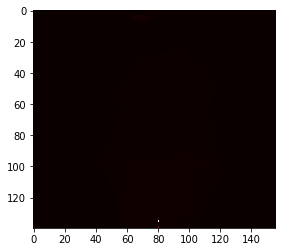

--
alpha: 2^-18
Correlation: 0.345724036614
Score: 0.000177712458215
Heatmap:



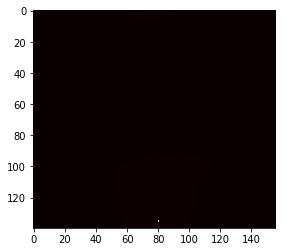

--
alpha: 2^-19
Correlation: 0.111885714833
Score: 5.56515377131e-05
Heatmap:



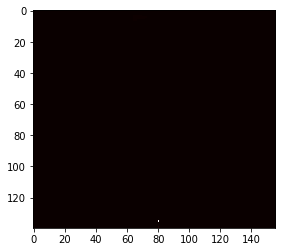

--
alpha: 2^-20
Correlation: 0.0362155905786
Score: 1.70759936143e-05
Heatmap:



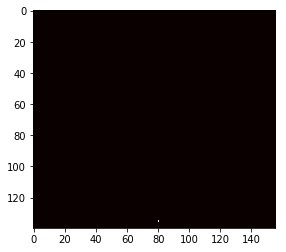

--
alpha: 2^-21
Correlation: 0.0090351892725
Score: 3.75486998759e-06
Heatmap:



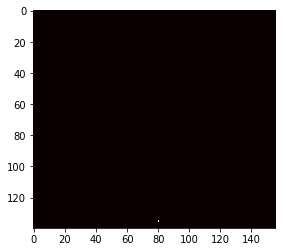

--
alpha: 2^-22
Correlation: 0.00271251005078
Score: 8.99821163089e-07
Heatmap:



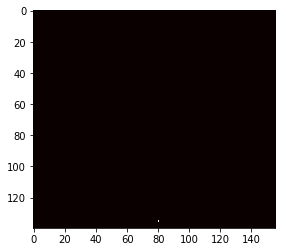

--
alpha: 2^-23
Correlation: 0.0014263343028
Score: 3.83435973904e-07
Heatmap:



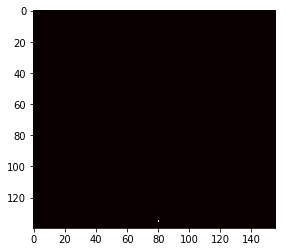

--
alpha: 2^-24
Correlation: 0.000434512030961
Score: 5.28555127875e-08
Heatmap:



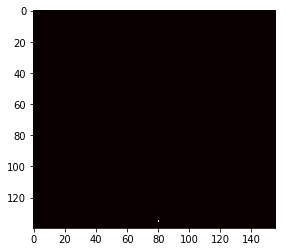

--
alpha: 2^-25
Correlation: 0.000310156663982
Score: 2.41885217443e-08
Heatmap:



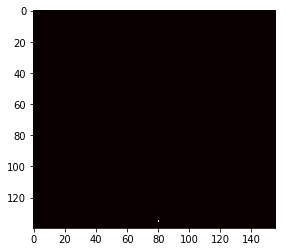

--
alpha: 2^-26
Correlation: 0.000188867334814
Score: 4.42792952316e-09
Heatmap:



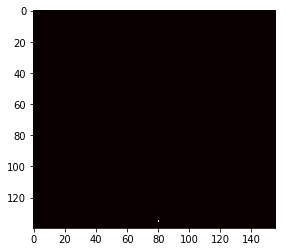

--
alpha: 2^-27
Correlation: 0.000150025356584
Score: 1.03487418501e-09
Heatmap:



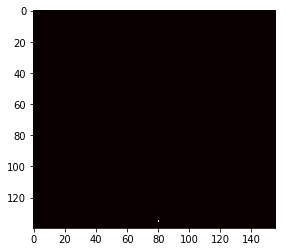

--
alpha: 2^-28
Correlation: 0.00013548864813
Score: 3.30279569038e-10
Heatmap:



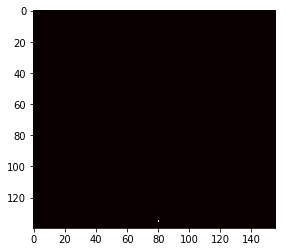

--
alpha: 2^-29
Correlation: 0.000126449144292
Score: 8.25944500482e-11
Heatmap:



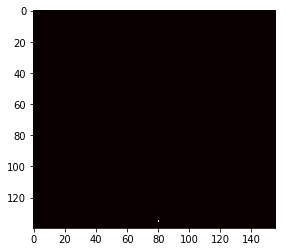

--
alpha: 2^-30
Correlation: 0.000122141006072
Score: 2.15674063245e-11
Heatmap:



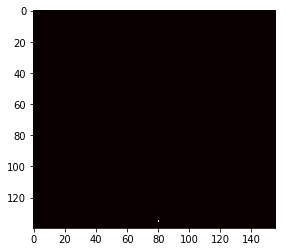

****


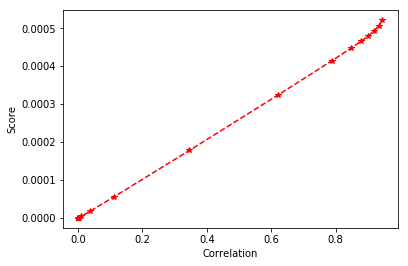

In [5]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [30, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.031124795167
Score: 0.0152010265135
Heatmap:



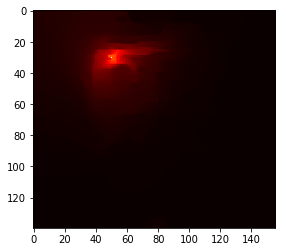

--
alpha: 2^-11
Correlation: 0.02004226227
Score: 0.00952578251086
Heatmap:



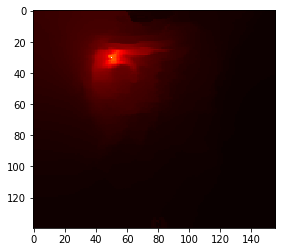

--
alpha: 2^-12
Correlation: 0.013222814427
Score: 0.00615559050774
Heatmap:



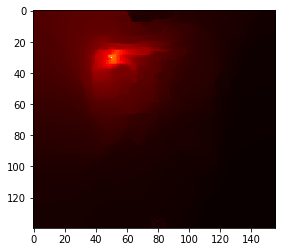

--
alpha: 2^-13
Correlation: 0.00927659715831
Score: 0.00425643773797
Heatmap:



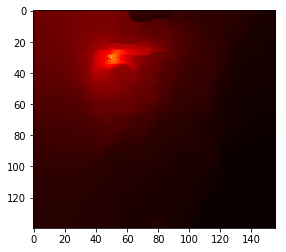

--
alpha: 2^-14
Correlation: 0.00708763073237
Score: 0.00322448548164
Heatmap:



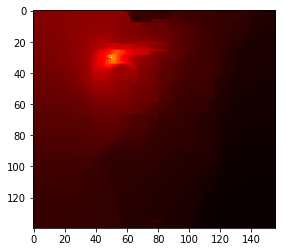

--
alpha: 2^-15
Correlation: 0.005626246558
Score: 0.00254392034444
Heatmap:



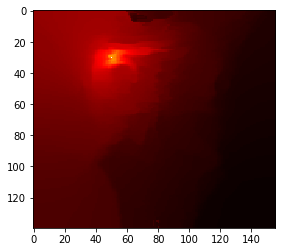

--
alpha: 2^-16
Correlation: 0.00507045704479
Score: 0.00229013422615
Heatmap:



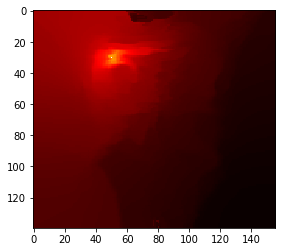

--
alpha: 2^-17
Correlation: 0.00494500320404
Score: 0.00223252076159
Heatmap:



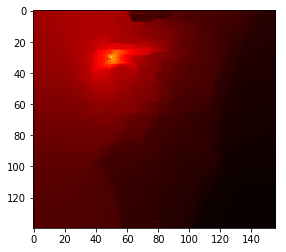

--
alpha: 2^-18
Correlation: 0.00467682320278
Score: 0.00211011193127
Heatmap:



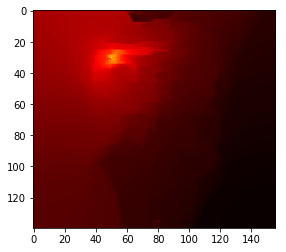

--
alpha: 2^-19
Correlation: 0.00464958581609
Score: 0.00209761026301
Heatmap:



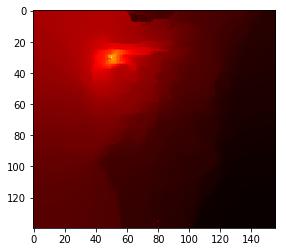

--
alpha: 2^-20
Correlation: 0.00459951759689
Score: 0.00207486276932
Heatmap:



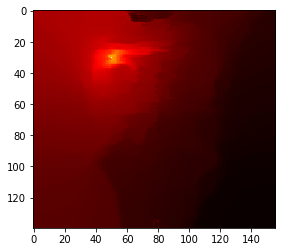

--
alpha: 2^-21
Correlation: 0.00457138476888
Score: 0.00206188258603
Heatmap:



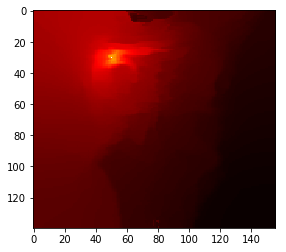

--
alpha: 2^-22
Correlation: 0.00450303112125
Score: 0.00203079340044
Heatmap:



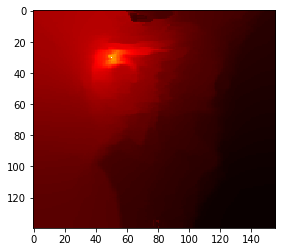

--
alpha: 2^-23
Correlation: 0.00450143597392
Score: 0.00202905984056
Heatmap:



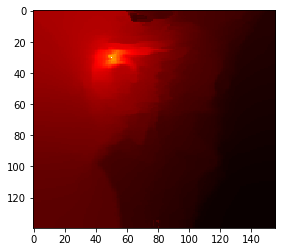

--
alpha: 2^-24
Correlation: 0.00475391048574
Score: 0.00214498810788
Heatmap:



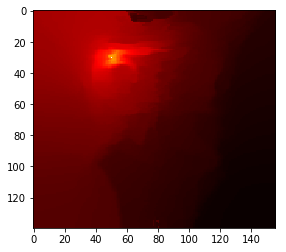

--
alpha: 2^-25
Correlation: 0.00477779326206
Score: 0.00215558881855
Heatmap:



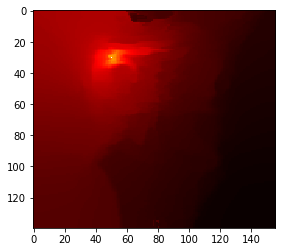

--
alpha: 2^-26
Correlation: 0.00422158700504
Score: 0.00190226132122
Heatmap:



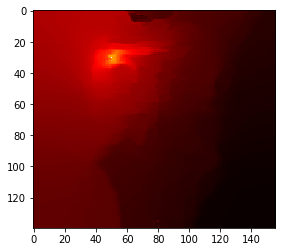

--
alpha: 2^-27
Correlation: 0.00446492581231
Score: 0.00201332422314
Heatmap:



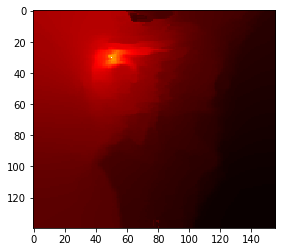

--
alpha: 2^-28
Correlation: 0.00461341597793
Score: 0.00208092394274
Heatmap:



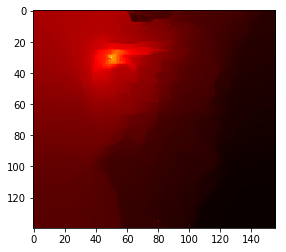

--
alpha: 2^-29
Correlation: 0.00448560790761
Score: 0.00202298317983
Heatmap:



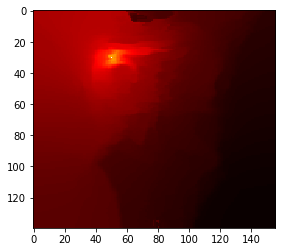

--
alpha: 2^-30
Correlation: 0.00455616277269
Score: 0.00205509124365
Heatmap:



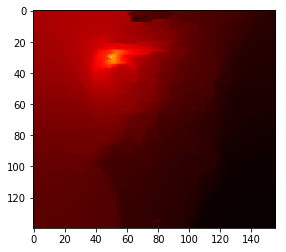

****


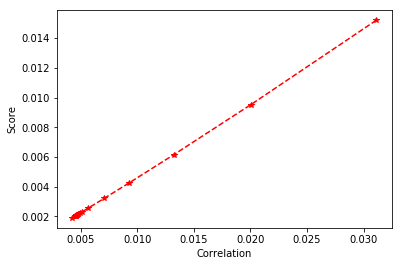

--------Seed [30, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0311278288717
Score: 0.0126701033456
Heatmap:



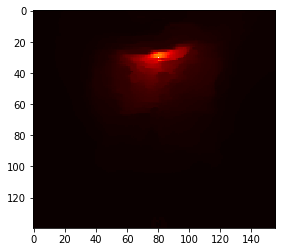

--
alpha: 2^-11
Correlation: 0.0223868391467
Score: 0.00890591172756
Heatmap:



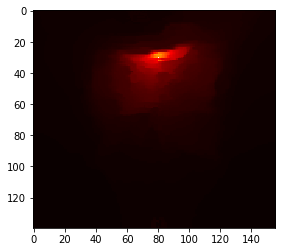

--
alpha: 2^-12
Correlation: 0.0175503959706
Score: 0.00689892984599
Heatmap:



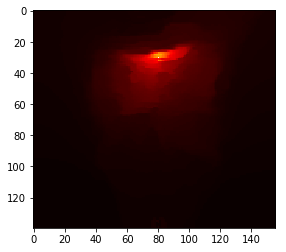

--
alpha: 2^-13
Correlation: 0.0146938350348
Score: 0.00574216762219
Heatmap:



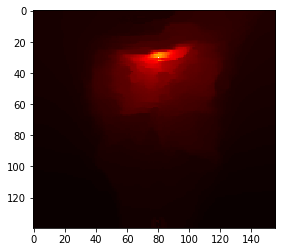

--
alpha: 2^-14
Correlation: 0.013627504213
Score: 0.00531761921336
Heatmap:



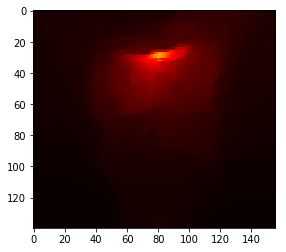

--
alpha: 2^-15
Correlation: 0.0128052304191
Score: 0.00499207316368
Heatmap:



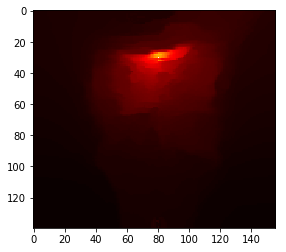

--
alpha: 2^-16
Correlation: 0.0123822217196
Score: 0.00482567453137
Heatmap:



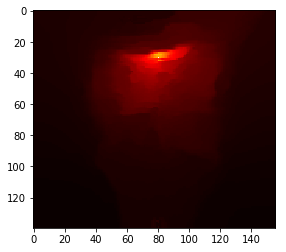

--
alpha: 2^-17
Correlation: 0.0124315430895
Score: 0.0048447107154
Heatmap:



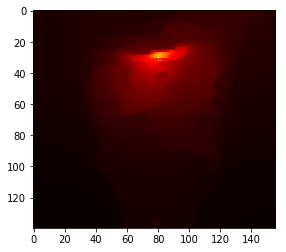

--
alpha: 2^-18
Correlation: 0.0119876167751
Score: 0.00467033621011
Heatmap:



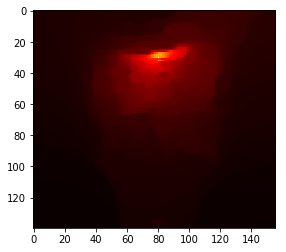

--
alpha: 2^-19
Correlation: 0.0121965359344
Score: 0.0047525767444
Heatmap:



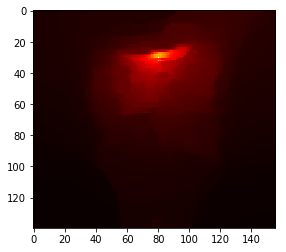

--
alpha: 2^-20
Correlation: 0.0120327856031
Score: 0.00468830313415
Heatmap:



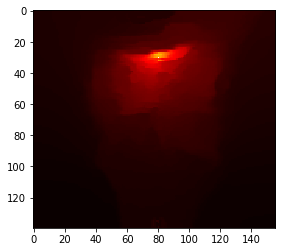

--
alpha: 2^-21
Correlation: 0.0120287010251
Score: 0.00468696397477
Heatmap:



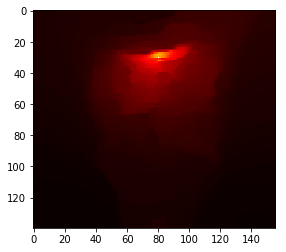

--
alpha: 2^-22
Correlation: 0.0120367330501
Score: 0.00468976653993
Heatmap:



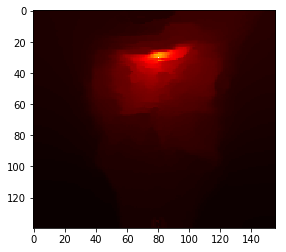

--
alpha: 2^-23
Correlation: 0.0120983329643
Score: 0.00471401168595
Heatmap:



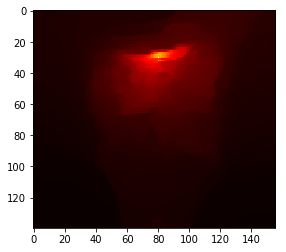

--
alpha: 2^-24
Correlation: 0.0119987656876
Score: 0.00467518578075
Heatmap:



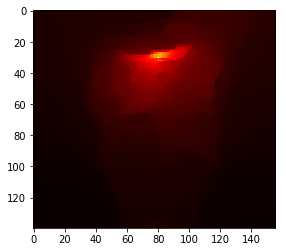

--
alpha: 2^-25
Correlation: 0.0118654634331
Score: 0.0046225408089
Heatmap:



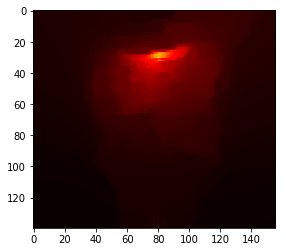

--
alpha: 2^-26
Correlation: 0.0120439443734
Score: 0.00469270570727
Heatmap:



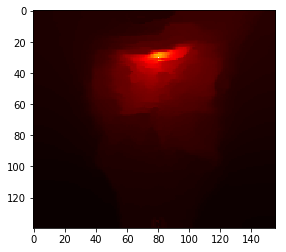

--
alpha: 2^-27
Correlation: 0.0121522585148
Score: 0.00473523346241
Heatmap:



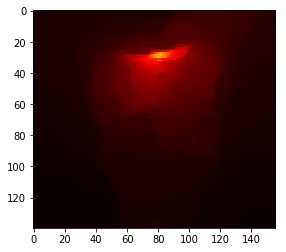

--
alpha: 2^-28
Correlation: 0.0120588214291
Score: 0.00469868639515
Heatmap:



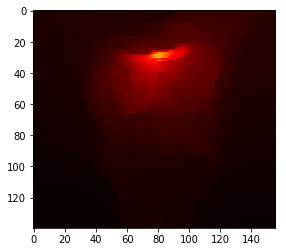

--
alpha: 2^-29
Correlation: 0.012135215601
Score: 0.00472858539993
Heatmap:



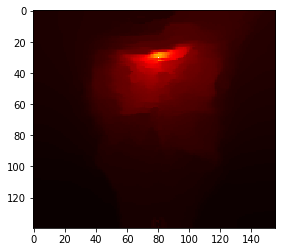

--
alpha: 2^-30
Correlation: 0.0119810643417
Score: 0.00466823345141
Heatmap:



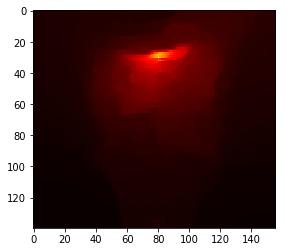

****


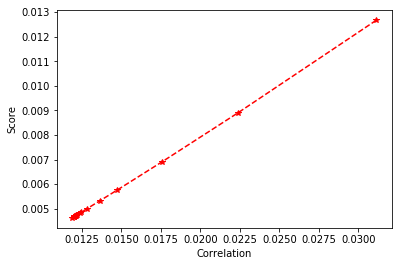

--------Seed [30, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0247038844331
Score: 0.0145718292575
Heatmap:



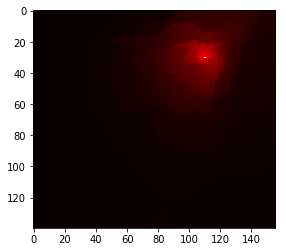

--
alpha: 2^-11
Correlation: 0.0147722121038
Score: 0.00841601693149
Heatmap:



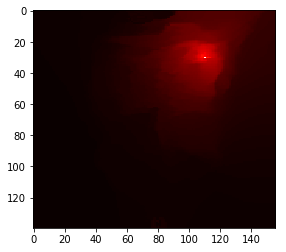

--
alpha: 2^-12
Correlation: 0.00929199459769
Score: 0.00515266097948
Heatmap:



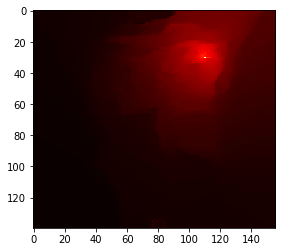

--
alpha: 2^-13
Correlation: 0.00651851522312
Score: 0.00355447767586
Heatmap:



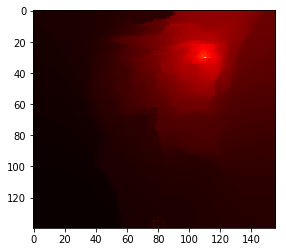

--
alpha: 2^-14
Correlation: 0.00523031483079
Score: 0.00282836421206
Heatmap:



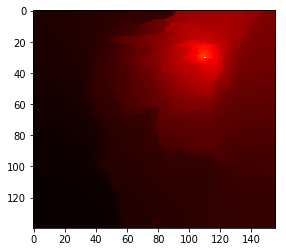

--
alpha: 2^-15
Correlation: 0.00420309764678
Score: 0.00225946105351
Heatmap:



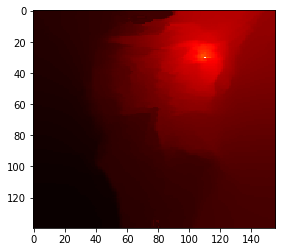

--
alpha: 2^-16
Correlation: 0.00380951416433
Score: 0.00204379077983
Heatmap:



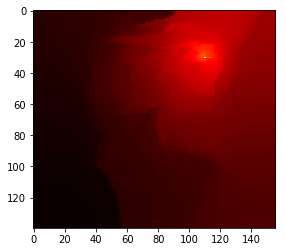

--
alpha: 2^-17
Correlation: 0.00357900760417
Score: 0.00191818036657
Heatmap:



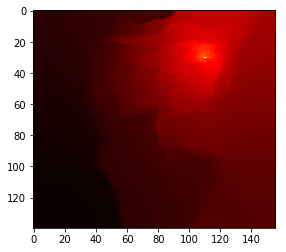

--
alpha: 2^-18
Correlation: 0.00349642129445
Score: 0.00187334762679
Heatmap:



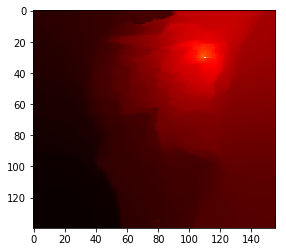

--
alpha: 2^-19
Correlation: 0.00337976433498
Score: 0.00180998404263
Heatmap:



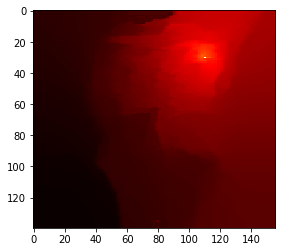

--
alpha: 2^-20
Correlation: 0.00327620181721
Score: 0.00175410969133
Heatmap:



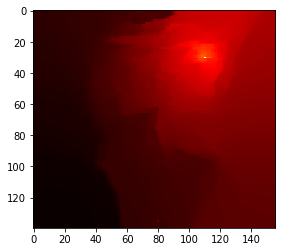

--
alpha: 2^-21
Correlation: 0.00350285631027
Score: 0.00187662179363
Heatmap:



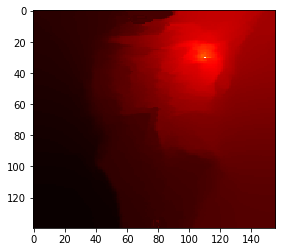

--
alpha: 2^-22
Correlation: 0.00339955720445
Score: 0.00182064251496
Heatmap:



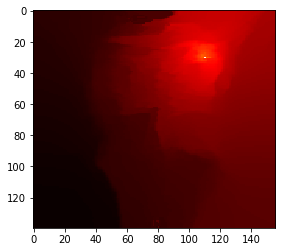

--
alpha: 2^-23
Correlation: 0.00340935830048
Score: 0.00182613084873
Heatmap:



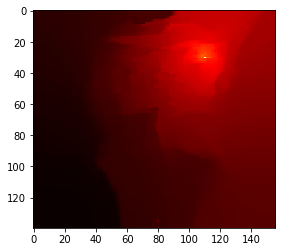

--
alpha: 2^-24
Correlation: 0.00323785298065
Score: 0.00173338879951
Heatmap:



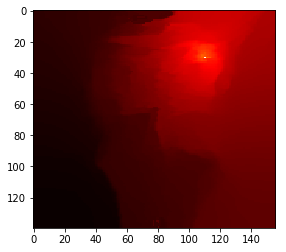

--
alpha: 2^-25
Correlation: 0.00339529005853
Score: 0.00181849964938
Heatmap:



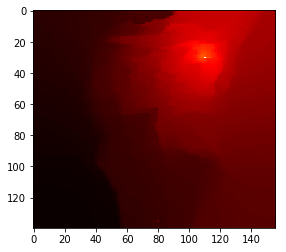

--
alpha: 2^-26
Correlation: 0.00337585480158
Score: 0.00180799279552
Heatmap:



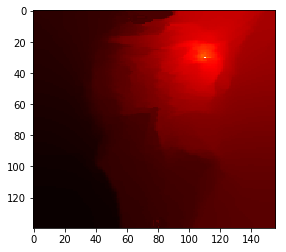

--
alpha: 2^-27
Correlation: 0.00327395479465
Score: 0.00175274103954
Heatmap:



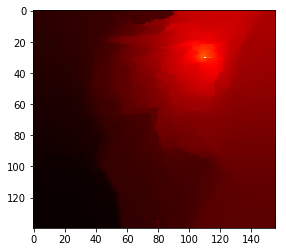

--
alpha: 2^-28
Correlation: 0.00322212803318
Score: 0.00172492224354
Heatmap:



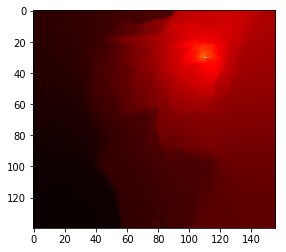

--
alpha: 2^-29
Correlation: 0.00336973785865
Score: 0.00180452677127
Heatmap:



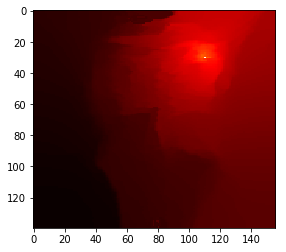

--
alpha: 2^-30
Correlation: 0.00331081360163
Score: 0.00177232658716
Heatmap:



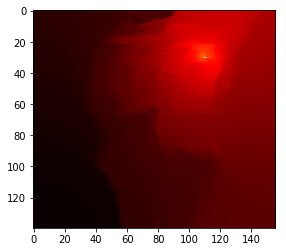

****


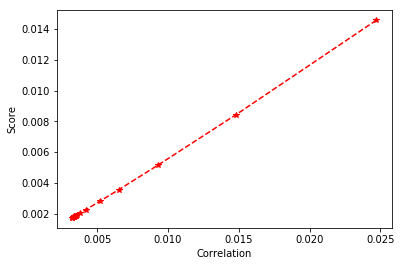

--------Seed [62, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0265417240236
Score: 0.0147814735304
Heatmap:



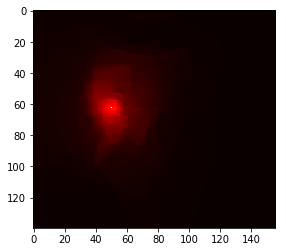

--
alpha: 2^-11
Correlation: 0.0169983795335
Score: 0.00921128091612
Heatmap:



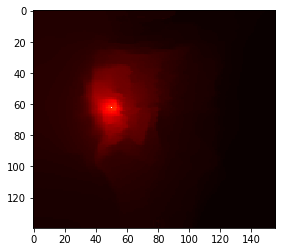

--
alpha: 2^-12
Correlation: 0.0131009628375
Score: 0.00701347752747
Heatmap:



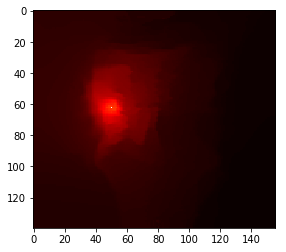

--
alpha: 2^-13
Correlation: 0.00961646421828
Score: 0.005086932396
Heatmap:



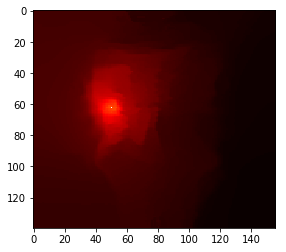

--
alpha: 2^-14
Correlation: 0.00708746478247
Score: 0.00371603184429
Heatmap:



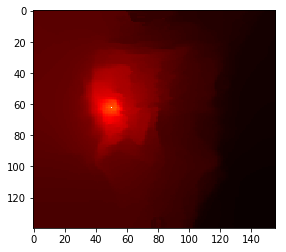

--
alpha: 2^-15
Correlation: 0.00578759371023
Score: 0.00302080928069
Heatmap:



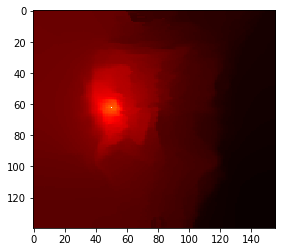

--
alpha: 2^-16
Correlation: 0.0052425950457
Score: 0.00273190562569
Heatmap:



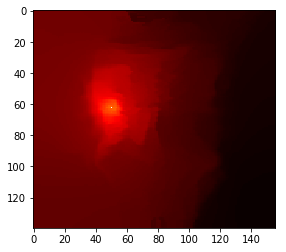

--
alpha: 2^-17
Correlation: 0.00500097857349
Score: 0.00260337556511
Heatmap:



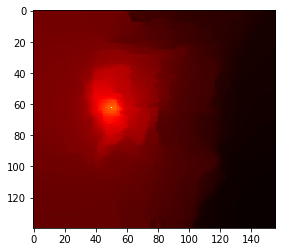

--
alpha: 2^-18
Correlation: 0.00440998619248
Score: 0.00229327302971
Heatmap:



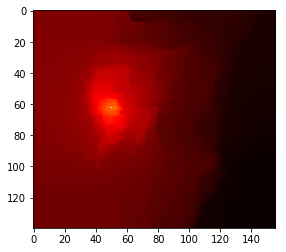

--
alpha: 2^-19
Correlation: 0.00451276359037
Score: 0.00234727015389
Heatmap:



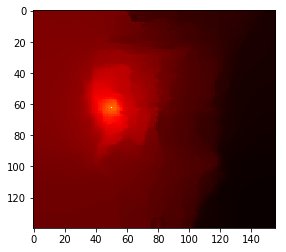

--
alpha: 2^-20
Correlation: 0.00431815209243
Score: 0.00224517964504
Heatmap:



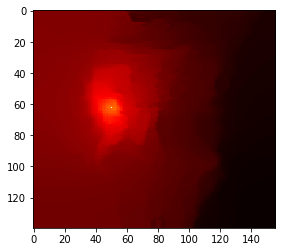

--
alpha: 2^-21
Correlation: 0.00471550154714
Score: 0.00245332071025
Heatmap:



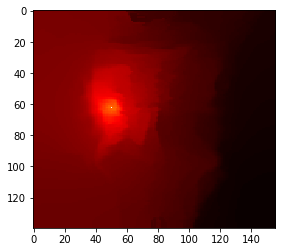

--
alpha: 2^-22
Correlation: 0.00440650430835
Score: 0.00229136777525
Heatmap:



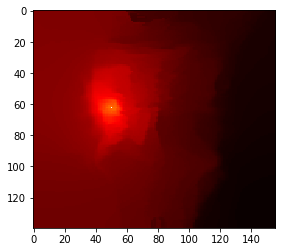

--
alpha: 2^-23
Correlation: 0.00440747683075
Score: 0.00229185159301
Heatmap:



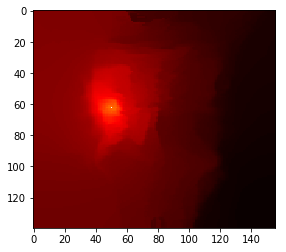

--
alpha: 2^-24
Correlation: 0.00486767005377
Score: 0.0025333223943
Heatmap:



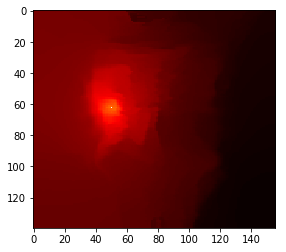

--
alpha: 2^-25
Correlation: 0.00464387748485
Score: 0.00241586166255
Heatmap:



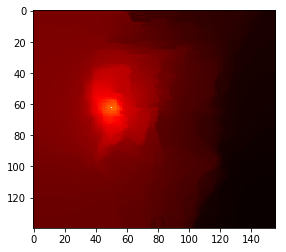

--
alpha: 2^-26
Correlation: 0.00437332208582
Score: 0.00227411419031
Heatmap:



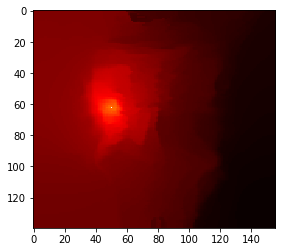

--
alpha: 2^-27
Correlation: 0.00434021929431
Score: 0.00225671985481
Heatmap:



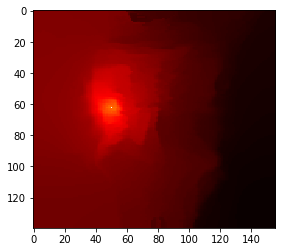

--
alpha: 2^-28
Correlation: 0.00462201992597
Score: 0.00240436251367
Heatmap:



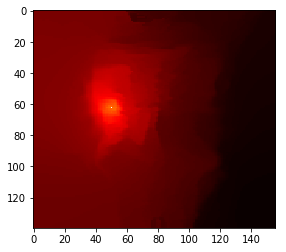

--
alpha: 2^-29
Correlation: 0.00460642010395
Score: 0.00239528007601
Heatmap:



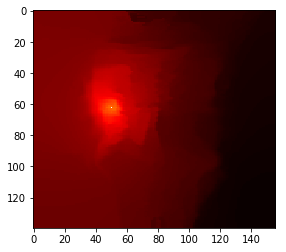

--
alpha: 2^-30
Correlation: 0.00457558431355
Score: 0.00237986776865
Heatmap:



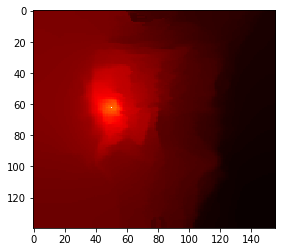

****


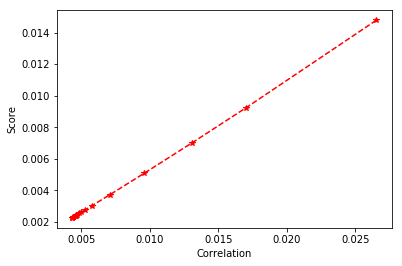

--------Seed [62, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0489633478192
Score: 0.0288051763313
Heatmap:



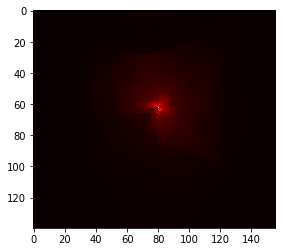

--
alpha: 2^-11
Correlation: 0.0320545580892
Score: 0.0186050682386
Heatmap:



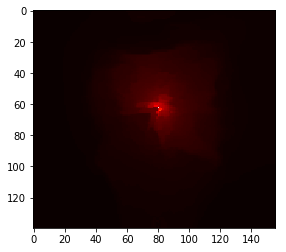

--
alpha: 2^-12
Correlation: 0.0232118500942
Score: 0.0133652808937
Heatmap:



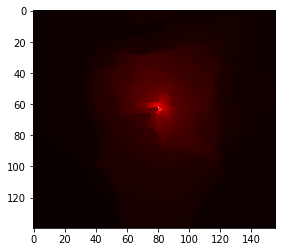

--
alpha: 2^-13
Correlation: 0.0186684322462
Score: 0.0107083628386
Heatmap:



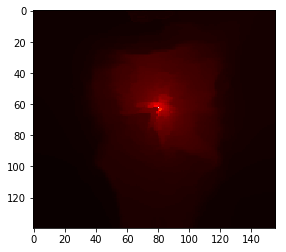

--
alpha: 2^-14
Correlation: 0.016437022612
Score: 0.00941353811736
Heatmap:



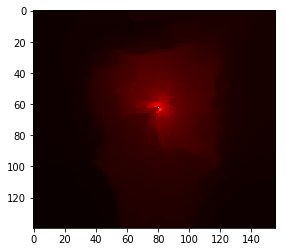

--
alpha: 2^-15
Correlation: 0.0151077145328
Score: 0.00864526176906
Heatmap:



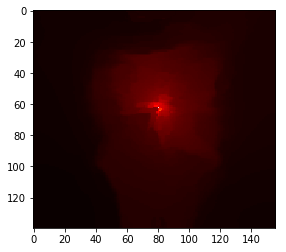

--
alpha: 2^-16
Correlation: 0.0144609789004
Score: 0.00827138827701
Heatmap:



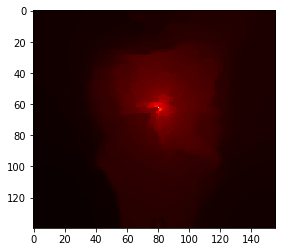

--
alpha: 2^-17
Correlation: 0.0141676947306
Score: 0.00810397924718
Heatmap:



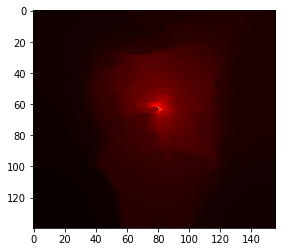

--
alpha: 2^-18
Correlation: 0.0142198815344
Score: 0.00813371980934
Heatmap:



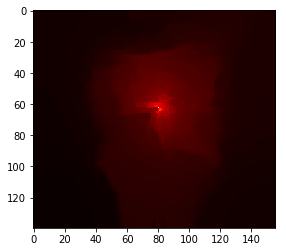

--
alpha: 2^-19
Correlation: 0.0138135822199
Score: 0.00790020076766
Heatmap:



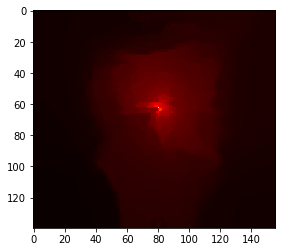

--
alpha: 2^-20
Correlation: 0.0139634154879
Score: 0.00798614887976
Heatmap:



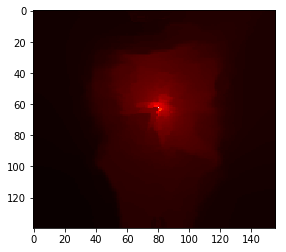

--
alpha: 2^-21
Correlation: 0.0138804003656
Score: 0.007938635561
Heatmap:



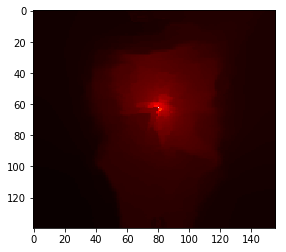

--
alpha: 2^-22
Correlation: 0.0136961706232
Score: 0.00783304817493
Heatmap:



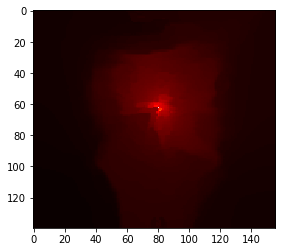

--
alpha: 2^-23
Correlation: 0.0138168878652
Score: 0.00790200487405
Heatmap:



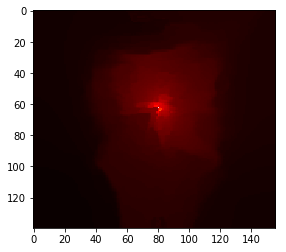

--
alpha: 2^-24
Correlation: 0.0136206655058
Score: 0.0077895740542
Heatmap:



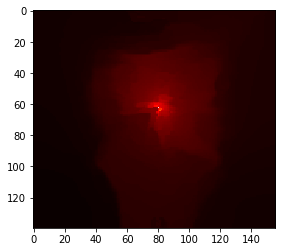

--
alpha: 2^-25
Correlation: 0.0139562671777
Score: 0.00798212503714
Heatmap:



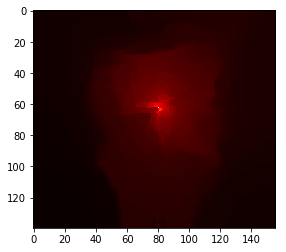

--
alpha: 2^-26
Correlation: 0.0135744495366
Score: 0.0077627922332
Heatmap:



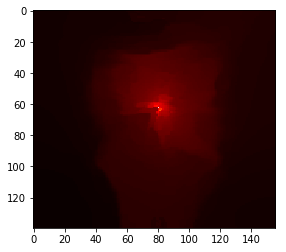

--
alpha: 2^-27
Correlation: 0.0138919198828
Score: 0.00794463168686
Heatmap:



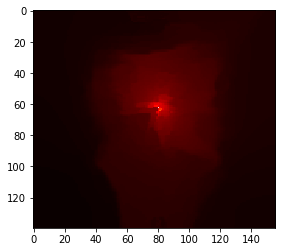

--
alpha: 2^-28
Correlation: 0.013963743881
Score: 0.00798659866738
Heatmap:



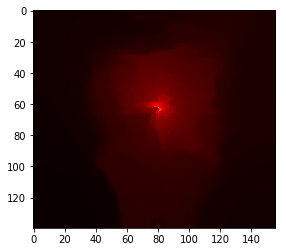

--
alpha: 2^-29
Correlation: 0.0138490405519
Score: 0.00792064590118
Heatmap:



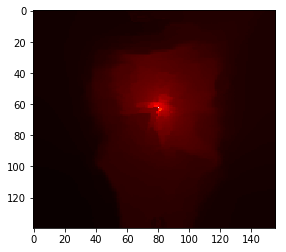

--
alpha: 2^-30
Correlation: 0.0137275216391
Score: 0.00785096029182
Heatmap:



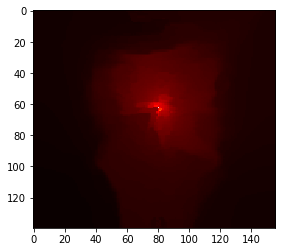

****


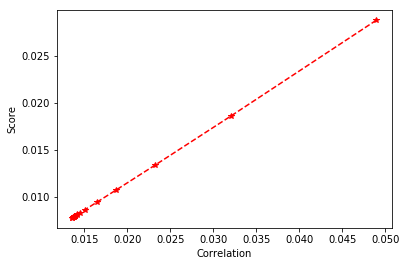

--------Seed [62, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0297746487399
Score: 0.0156060579468
Heatmap:



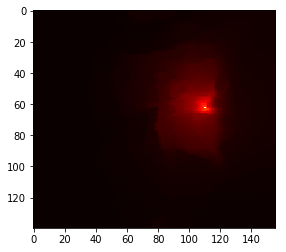

--
alpha: 2^-11
Correlation: 0.0171822215614
Score: 0.00870617674571
Heatmap:



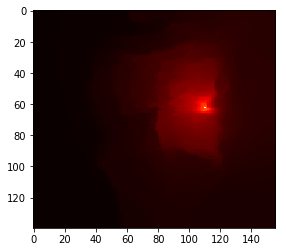

--
alpha: 2^-12
Correlation: 0.0125033984197
Score: 0.00623323656043
Heatmap:



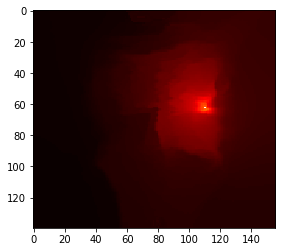

--
alpha: 2^-13
Correlation: 0.00809035217732
Score: 0.00395858674077
Heatmap:



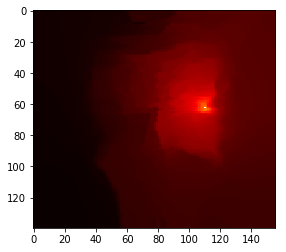

--
alpha: 2^-14
Correlation: 0.00599120363134
Score: 0.00290123203712
Heatmap:



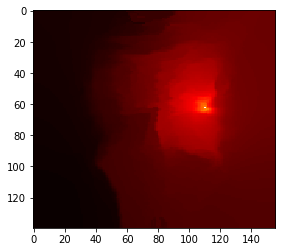

--
alpha: 2^-15
Correlation: 0.00501675848301
Score: 0.00241742642238
Heatmap:



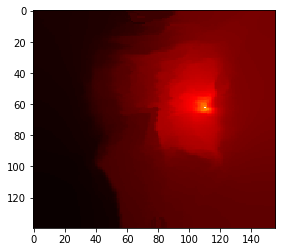

--
alpha: 2^-16
Correlation: 0.00440790814718
Score: 0.00211764731195
Heatmap:



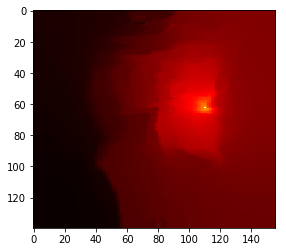

--
alpha: 2^-17
Correlation: 0.00396020243286
Score: 0.0018995233963
Heatmap:



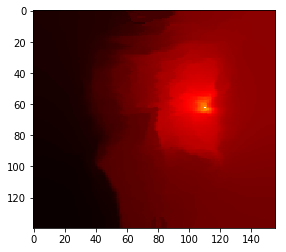

--
alpha: 2^-18
Correlation: 0.00382965546165
Score: 0.00183606192928
Heatmap:



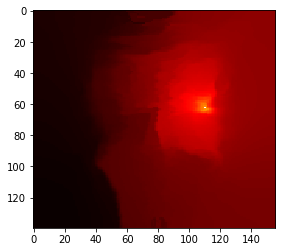

--
alpha: 2^-19
Correlation: 0.00353165166651
Score: 0.00169179118557
Heatmap:



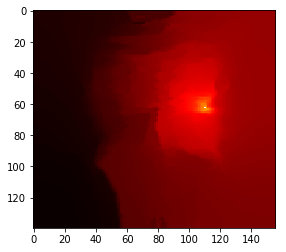

--
alpha: 2^-20
Correlation: 0.00377573844791
Score: 0.00180970792299
Heatmap:



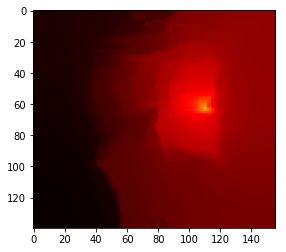

--
alpha: 2^-21
Correlation: 0.00388537842817
Score: 0.00186286972584
Heatmap:



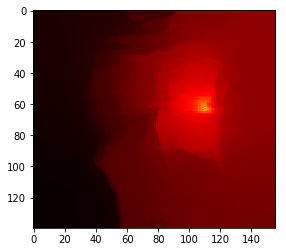

--
alpha: 2^-22
Correlation: 0.00362645339605
Score: 0.00173757378581
Heatmap:



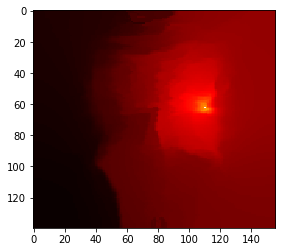

--
alpha: 2^-23
Correlation: 0.00369902459018
Score: 0.00177250440053
Heatmap:



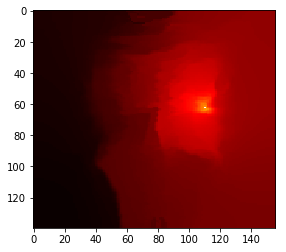

--
alpha: 2^-24
Correlation: 0.00359821852861
Score: 0.00172395821227
Heatmap:



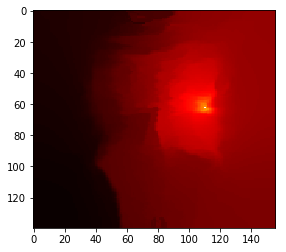

--
alpha: 2^-25
Correlation: 0.00363796865238
Score: 0.00174311488071
Heatmap:



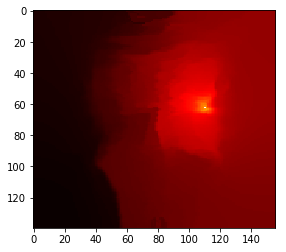

--
alpha: 2^-26
Correlation: 0.00346870300799
Score: 0.00166032510372
Heatmap:



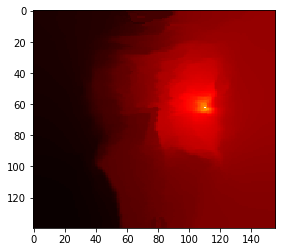

--
alpha: 2^-27
Correlation: 0.00341755561191
Score: 0.00163660847487
Heatmap:



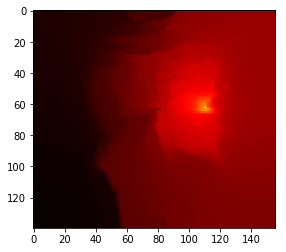

--
alpha: 2^-28
Correlation: 0.00377792710206
Score: 0.00181055059967
Heatmap:



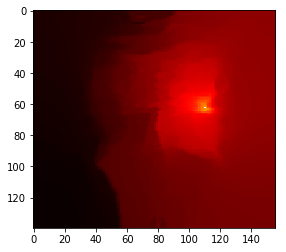

--
alpha: 2^-29
Correlation: 0.0035450011349
Score: 0.00169811742822
Heatmap:



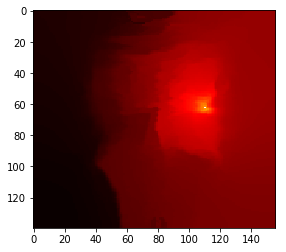

--
alpha: 2^-30
Correlation: 0.00361062542364
Score: 0.00172991152514
Heatmap:



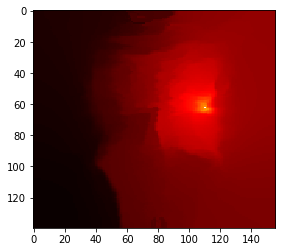

****


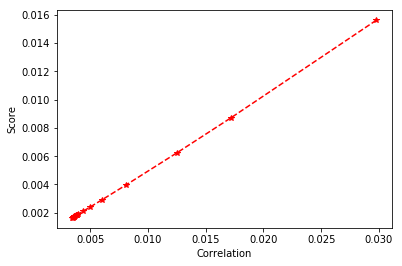

--------Seed [94, 50]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0224988961832
Score: 0.0122668111328
Heatmap:



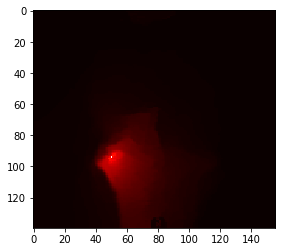

--
alpha: 2^-11
Correlation: 0.0135401147692
Score: 0.00709481064941
Heatmap:



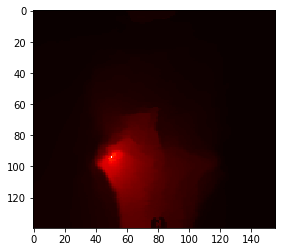

--
alpha: 2^-12
Correlation: 0.00932807626103
Score: 0.0047712220472
Heatmap:



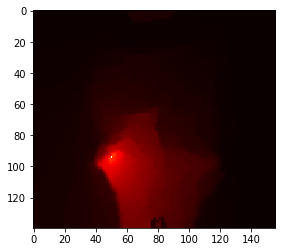

--
alpha: 2^-13
Correlation: 0.00721777747659
Score: 0.0036467479387
Heatmap:



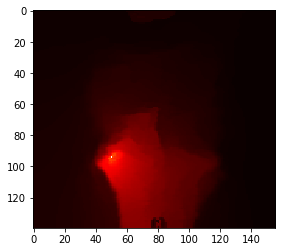

--
alpha: 2^-14
Correlation: 0.00608980779226
Score: 0.00306074251321
Heatmap:



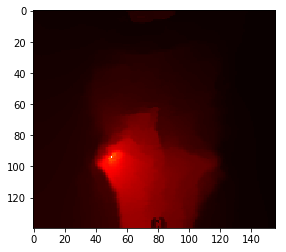

--
alpha: 2^-15
Correlation: 0.00561096378882
Score: 0.0028156823662
Heatmap:



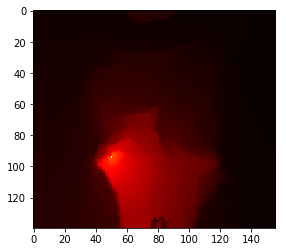

--
alpha: 2^-16
Correlation: 0.00534604778103
Score: 0.00268122825745
Heatmap:



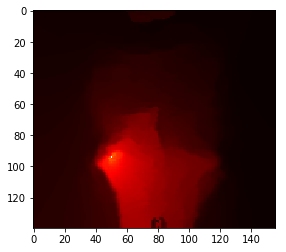

--
alpha: 2^-17
Correlation: 0.00532402850085
Score: 0.00267004354674
Heatmap:



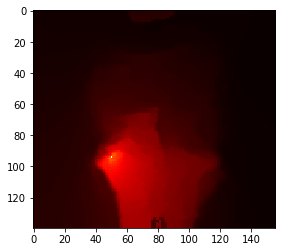

--
alpha: 2^-18
Correlation: 0.00518121754436
Score: 0.00259794451409
Heatmap:



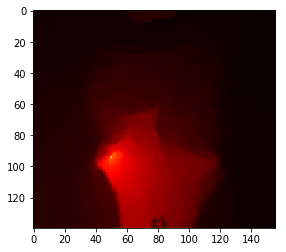

--
alpha: 2^-19
Correlation: 0.00519355202566
Score: 0.0026041852976
Heatmap:



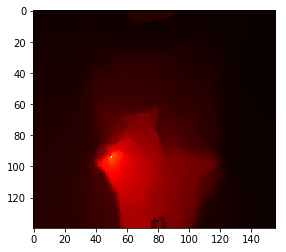

--
alpha: 2^-20
Correlation: 0.00518439888282
Score: 0.00259952730934
Heatmap:



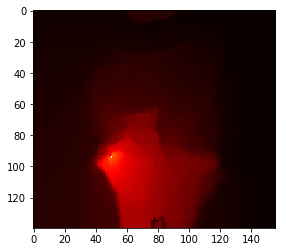

--
alpha: 2^-21
Correlation: 0.00512748871217
Score: 0.00257089032901
Heatmap:



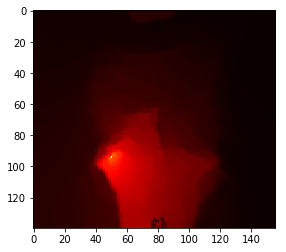

--
alpha: 2^-22
Correlation: 0.00516426408959
Score: 0.0025894732398
Heatmap:



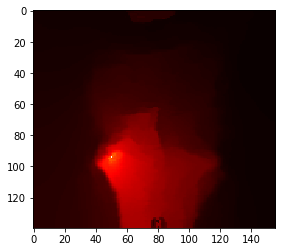

--
alpha: 2^-23
Correlation: 0.00512476225485
Score: 0.00256957724472
Heatmap:



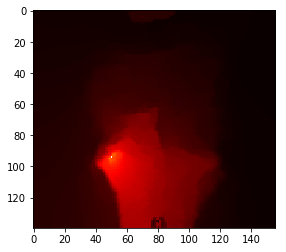

--
alpha: 2^-24
Correlation: 0.00505177077261
Score: 0.00253249179171
Heatmap:



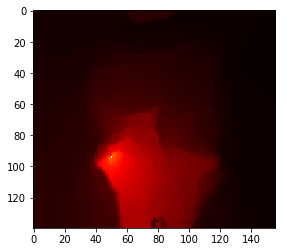

--
alpha: 2^-25
Correlation: 0.00520408647168
Score: 0.00260944698131
Heatmap:



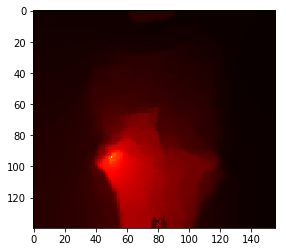

--
alpha: 2^-26
Correlation: 0.005102202133
Score: 0.0025582458232
Heatmap:



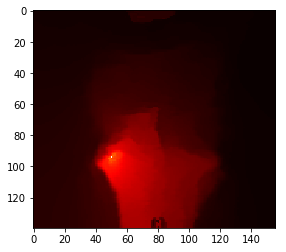

--
alpha: 2^-27
Correlation: 0.00507015789866
Score: 0.0025420123653
Heatmap:



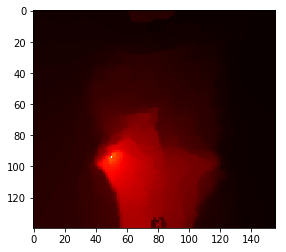

--
alpha: 2^-28
Correlation: 0.00518252099242
Score: 0.0025984330439
Heatmap:



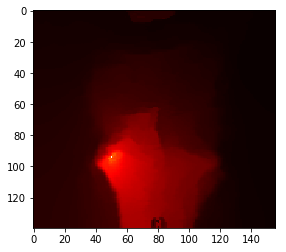

--
alpha: 2^-29
Correlation: 0.00515705964418
Score: 0.00258581989102
Heatmap:



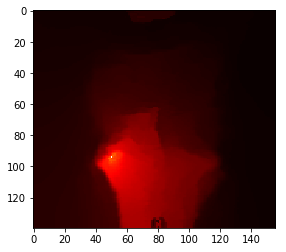

--
alpha: 2^-30
Correlation: 0.00519812494499
Score: 0.00260644140884
Heatmap:



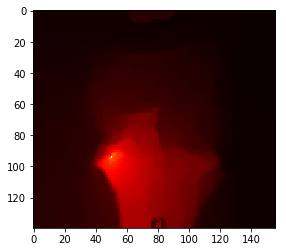

****


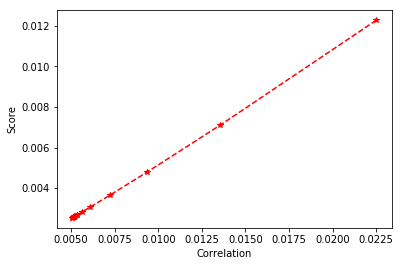

--------Seed [94, 80]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0314494195559
Score: 0.0162488289878
Heatmap:



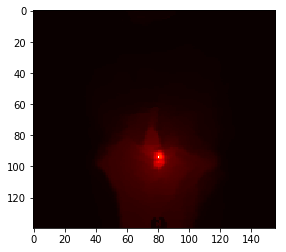

--
alpha: 2^-11
Correlation: 0.0174992308136
Score: 0.00872703950924
Heatmap:



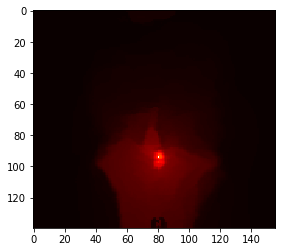

--
alpha: 2^-12
Correlation: 0.0112861294549
Score: 0.00549996398685
Heatmap:



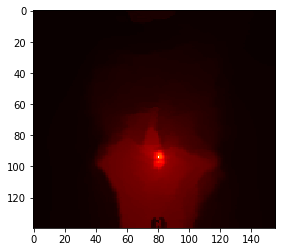

--
alpha: 2^-13
Correlation: 0.0084463652747
Score: 0.00406886609139
Heatmap:



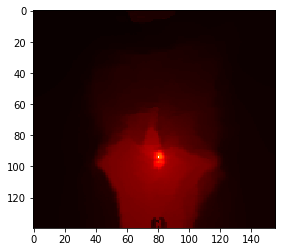

--
alpha: 2^-14
Correlation: 0.0071204348514
Score: 0.00341458548459
Heatmap:



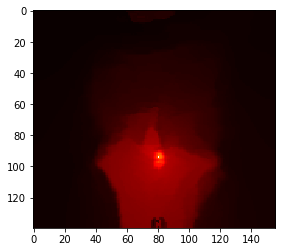

--
alpha: 2^-15
Correlation: 0.00650098337928
Score: 0.00311287645526
Heatmap:



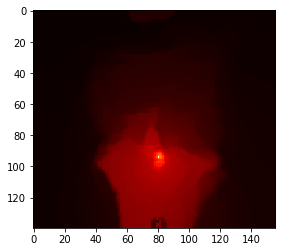

--
alpha: 2^-16
Correlation: 0.00619833490831
Score: 0.00296622902957
Heatmap:



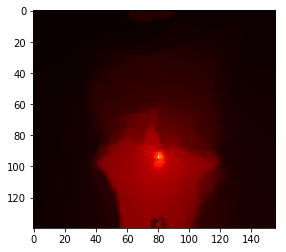

--
alpha: 2^-17
Correlation: 0.00605943273087
Score: 0.00289959207364
Heatmap:



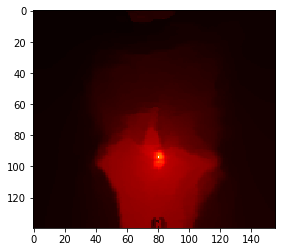

--
alpha: 2^-18
Correlation: 0.00593304610207
Score: 0.00283847156864
Heatmap:



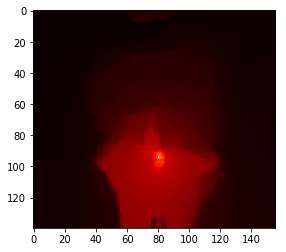

--
alpha: 2^-19
Correlation: 0.00589812707125
Score: 0.00282173560763
Heatmap:



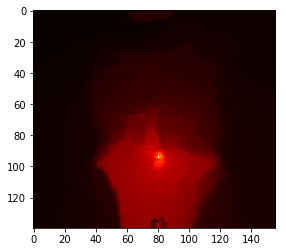

--
alpha: 2^-20
Correlation: 0.00589047477999
Score: 0.00281738655387
Heatmap:



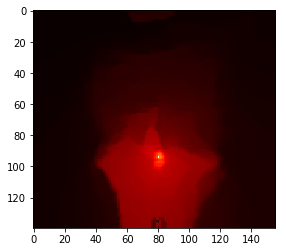

--
alpha: 2^-21
Correlation: 0.00588309902081
Score: 0.00281400442982
Heatmap:



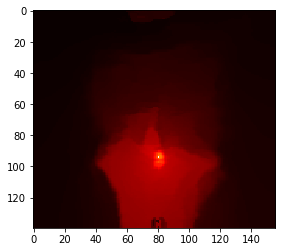

--
alpha: 2^-22
Correlation: 0.00591987946842
Score: 0.00283179659425
Heatmap:



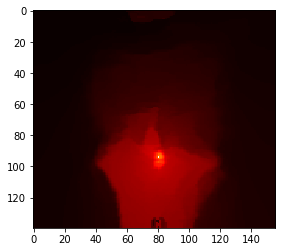

--
alpha: 2^-23
Correlation: 0.00588725771702
Score: 0.00281588093994
Heatmap:



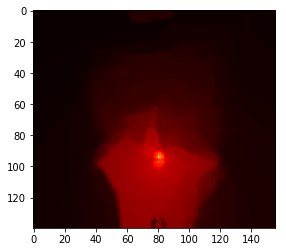

--
alpha: 2^-24
Correlation: 0.00586434524036
Score: 0.00280517857549
Heatmap:



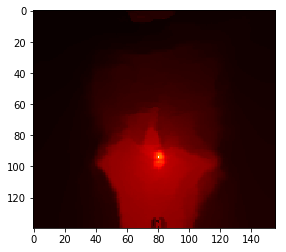

--
alpha: 2^-25
Correlation: 0.0058708244415
Score: 0.002808742917
Heatmap:



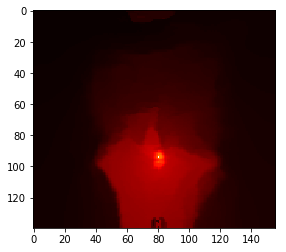

--
alpha: 2^-26
Correlation: 0.00590669805805
Score: 0.00282589395487
Heatmap:



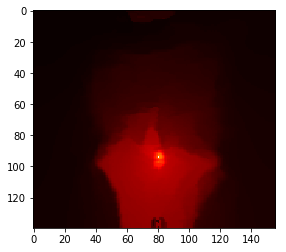

--
alpha: 2^-27
Correlation: 0.00588769252447
Score: 0.00281638164192
Heatmap:



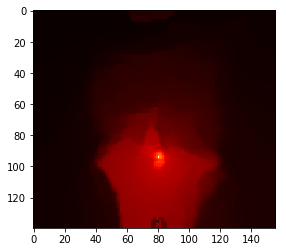

--
alpha: 2^-28
Correlation: 0.00586219280824
Score: 0.00280455359709
Heatmap:



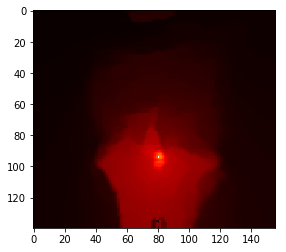

--
alpha: 2^-29
Correlation: 0.00586203456223
Score: 0.00280444060366
Heatmap:



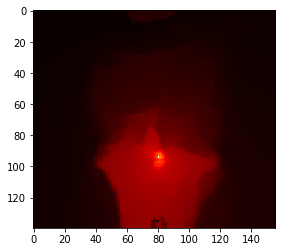

--
alpha: 2^-30
Correlation: 0.00592157835816
Score: 0.00283271882078
Heatmap:



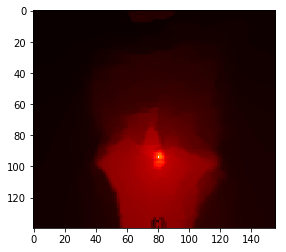

****


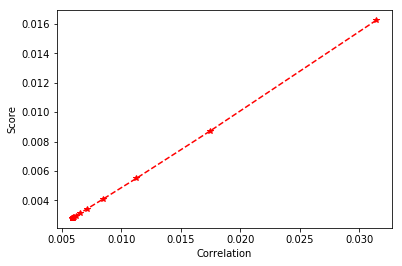

--------Seed [94, 110]
Threshold: 4.578754578754579e-05
--
alpha: 2^-10
Correlation: 0.0463453962584
Score: 0.0201918056501
Heatmap:



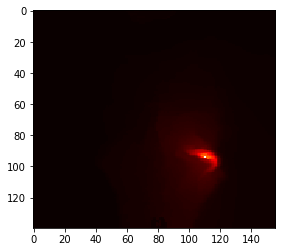

--
alpha: 2^-11
Correlation: 0.0322291299804
Score: 0.0138261914181
Heatmap:



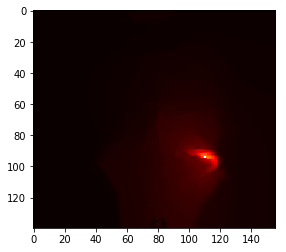

--
alpha: 2^-12
Correlation: 0.022078759454
Score: 0.00935061246808
Heatmap:



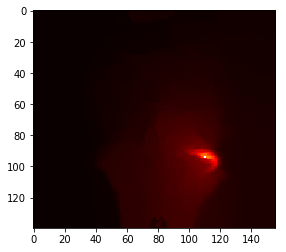

--
alpha: 2^-13
Correlation: 0.0152134491796
Score: 0.00637974865129
Heatmap:



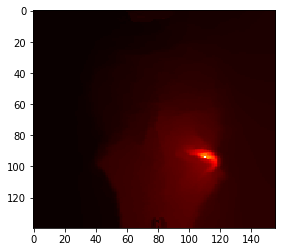

--
alpha: 2^-14
Correlation: 0.0119565815966
Score: 0.0049908985457
Heatmap:



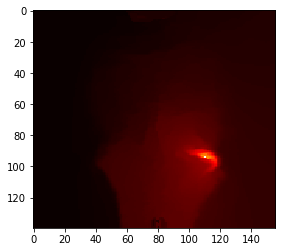

--
alpha: 2^-15
Correlation: 0.00999510975349
Score: 0.00416083466224
Heatmap:



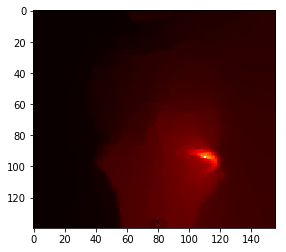

--
alpha: 2^-16
Correlation: 0.00880063464374
Score: 0.00365831080013
Heatmap:



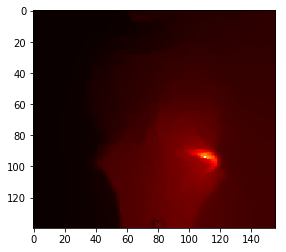

--
alpha: 2^-17
Correlation: 0.00859266833877
Score: 0.00357116784775
Heatmap:



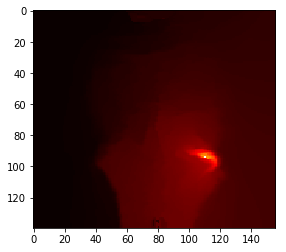

--
alpha: 2^-18
Correlation: 0.00824012206242
Score: 0.0034226901003
Heatmap:



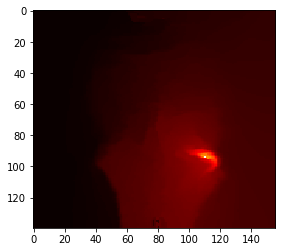

--
alpha: 2^-19
Correlation: 0.00798236197587
Score: 0.00331567997904
Heatmap:



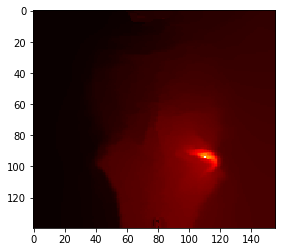

--
alpha: 2^-20
Correlation: 0.00822174146466
Score: 0.0034156356124
Heatmap:



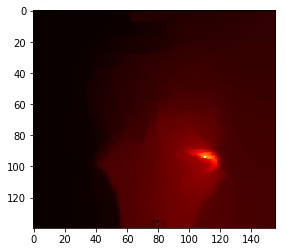

--
alpha: 2^-21
Correlation: 0.00815897715635
Score: 0.00338938514233
Heatmap:



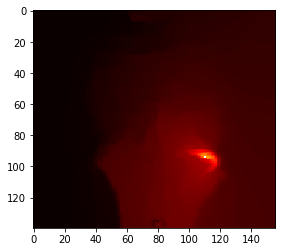

--
alpha: 2^-22
Correlation: 0.00806803484515
Score: 0.0033512176866
Heatmap:



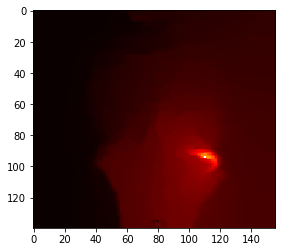

--
alpha: 2^-23
Correlation: 0.00728970445459
Score: 0.00302563461132
Heatmap:



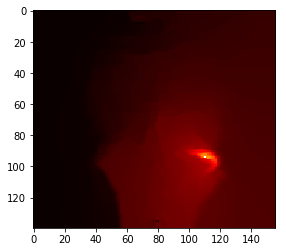

--
alpha: 2^-24
Correlation: 0.00799290995304
Score: 0.00332007603811
Heatmap:



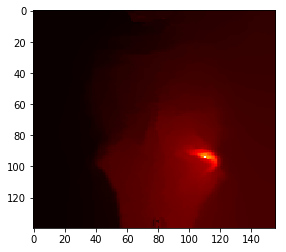

--
alpha: 2^-25
Correlation: 0.00785511732217
Score: 0.00326200204292
Heatmap:



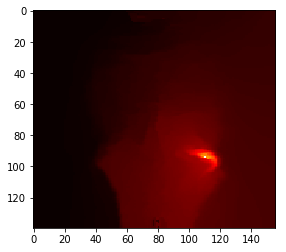

--
alpha: 2^-26
Correlation: 0.00835984405537
Score: 0.0034726744347
Heatmap:



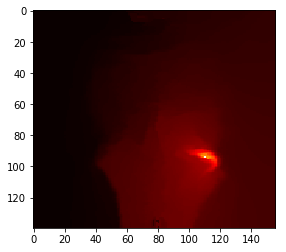

--
alpha: 2^-27
Correlation: 0.00788138336239
Score: 0.00327334325847
Heatmap:



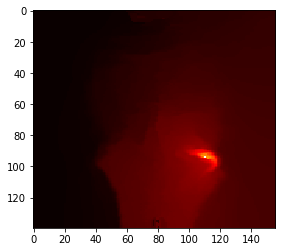

--
alpha: 2^-28
Correlation: 0.00787206941791
Score: 0.00326823260762
Heatmap:



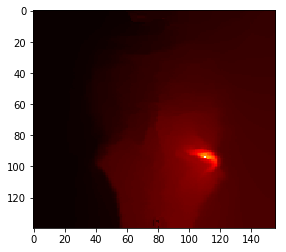

--
alpha: 2^-29
Correlation: 0.00792086772185
Score: 0.00328988416223
Heatmap:



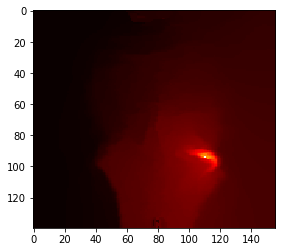

--
alpha: 2^-30
Correlation: 0.00824849655204
Score: 0.00342574564666
Heatmap:



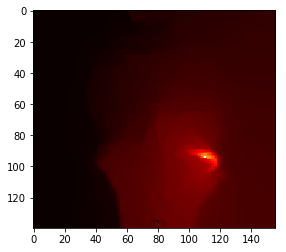

****


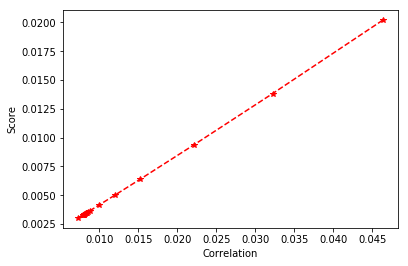

In [6]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

    # Saving
    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)

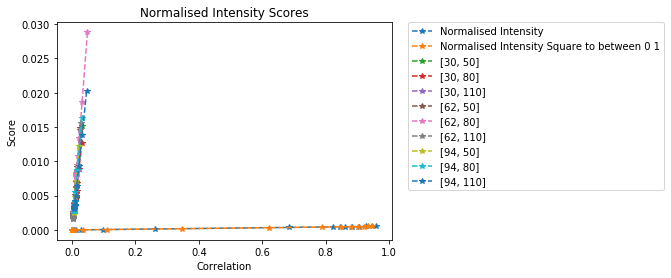

In [7]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [8]:
save_array(IMAGE + '_01-23-18' + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '_01-23-18' + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '_01-23-18' + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '_01-23-18' + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '_01-23-18' + '/' + 'seedList.data', seedList[2:])

In [4]:
alphaListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '_01-23-18' + '/' + 'seedList.data')

Print with saved arrays for future usage


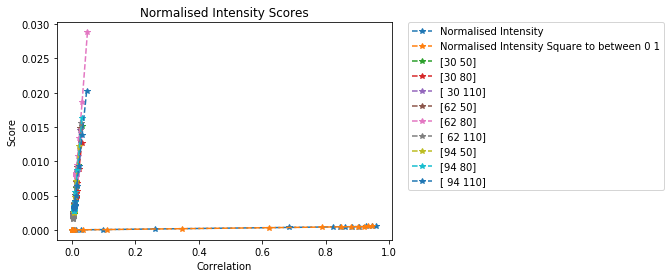

In [10]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
# plt.axis([.8,1,0,1])
plt.show()

Print with saved arrays for future usage


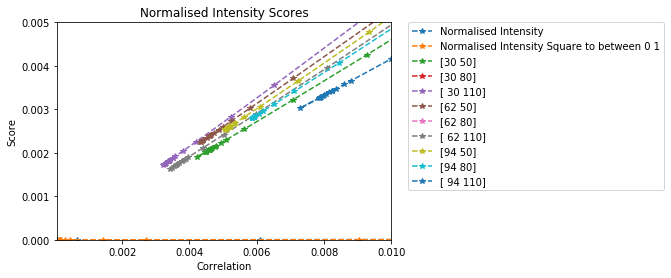

In [6]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.axis([1/20000, 1/100, 0, .005])
plt.show()